# NHL Canucks - Retention Score Distribution
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 28, 2022

In [4]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [5]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [6]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32913, 54)

### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 9)
Unseen Data For Predictions: (4172, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [8]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [9]:
model_matrix = compare_models(
    fold=10,
    include=["gbc","lightgbm","lr","xgboost"],
    sort="AUC"
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7827,0.8624,0.8077,0.7801,0.7937,0.5643,0.5647,0.3470
lightgbm,Light Gradient Boosting Machine,0.7687,0.8495,0.7832,0.7728,0.7779,0.5366,0.5368,0.1590
gbc,Gradient Boosting Classifier,0.7432,0.8171,0.7346,0.7609,0.7474,0.4865,0.4869,0.3900
lr,Logistic Regression,0.6417,0.6975,0.6133,0.6673,0.6391,0.2847,0.2857,0.0170


In [10]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7771,0.8578,0.8048,0.7736,0.7889,0.5530,0.5535
1,0.7766,0.8558,0.8144,0.7679,0.7905,0.5517,0.5528
2,0.7826,0.8654,0.8029,0.7826,0.7926,0.5642,0.5644
3,0.7886,0.8730,0.8144,0.7850,0.7994,0.5760,0.5765
4,0.7990,0.8682,0.8260,0.7939,0.8096,0.5969,0.5975
5,0.7816,0.8633,0.8038,0.7806,0.7920,0.5622,0.5625
6,0.7805,0.8604,0.8087,0.7765,0.7923,0.5598,0.5603
7,0.7850,0.8660,0.8058,0.7846,0.7951,0.5690,0.5692
8,0.7850,0.8652,0.8104,0.7818,0.7958,0.5689,0.5693
9,0.7710,0.8486,0.7863,0.7744,0.7803,0.5413,0.5413


### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5098, 54)

In [12]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
27815,7,2933,1857357,2021,Quarter,2054.4,2021-12-12,1.000000,46,TRUE,...,0,0,0.0,1,46,0,0,0,0.5947,0.4053
27816,7,5582,5332293,2021,Quarter,3625.3,2021-12-06,1.000000,22,TRUE,...,0,0,0.0,1,46,0,0,0,0.5776,0.4224
27817,7,6251,6081655,2021,Full Season,7254.7,2022-02-24,0.947368,95,TRUE,...,0,0,0.0,1,46,0,0,0,0.6978,0.3022
27818,7,6857,2173063,2021,Half Season,11888.6,2021-12-12,0.861111,33,TRUE,...,0,0,0.0,1,46,0,0,0,0.7996,0.2004
27819,7,7570,6905653,2021,Full Season,12818.7,2022-02-24,1.052632,102,TRUE,...,0,0,0.0,1,46,0,0,0,0.6691,0.3309


### We can see how many purchases there are in each probability bucket:

In [ ]:
#new_predictions = new_predictions[new_predictions["productGrouping"] == "Full Season"]
new_predictions["Score_1"].value_counts(bins=[0.5,0.6,0.7,0.8,0.9,1])

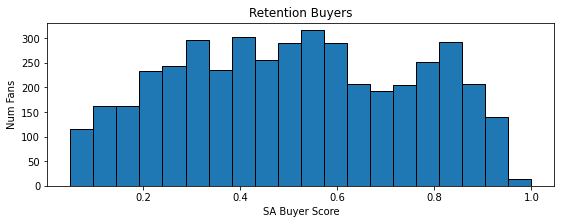

In [14]:
plt.subplot(1, 2, 1) #two rows, 1 column, index 1
plt.title("Retention Buyers")
plt.hist(new_predictions["Score_1"], bins=20, edgecolor="black", range=(0.05,1.0))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,2)
plt.show()

### Now let's load in the retention scores from SageMaker and compare the results:

In [23]:
df_sagemaker_scores = pd.read_json("inference_data (02-28-2022).csv", lines=True)
df_sagemaker_scores.info()

df_sagemaker_scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attendancePercent    5094 non-null   float64
 1   isNextYear_Buyer     5094 non-null   float64
 2   clientcode           5094 non-null   object 
 3   dimCustomerMasterId  5094 non-null   int64  
 4   lkupclientid         5094 non-null   int64  
 5   productGrouping      5094 non-null   object 
 6   recency              5094 non-null   int64  
 7   recentDate           5094 non-null   object 
 8   source_tenure        5094 non-null   int64  
 9   totalSpent           5094 non-null   float64
 10  year                 5094 non-null   int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 437.9+ KB


,attendancePercent,isNextYear_Buyer,clientcode,dimCustomerMasterId,lkupclientid,productGrouping,recency,recentDate,source_tenure,totalSpent,year
0,1.000000,0.1217,canucks,992,7,Quarter,0,2021-12-12,2555,1375.0,2021
1,1.090909,0.0581,canucks,3533,7,Half Season,0,2022-02-24,6935,3282.1,2021
2,1.000000,0.1109,canucks,4583,7,Quarter,0,2022-02-19,2555,1451.4,2021
3,1.000000,0.2816,canucks,5145,7,Quarter,0,2021-12-10,2555,887.6,2021
4,1.250000,0.0054,canucks,6324,7,Quarter,0,2022-02-24,365,1407.1,2021


In [24]:
df_sagemaker_scores["isNextYear_Buyer"].value_counts(bins=[0.5,0.6,0.7,0.8,0.9,1])

(0.499, 0.6]    27
(0.6, 0.7]      10
(0.7, 0.8]       2
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: isNextYear_Buyer, dtype: int64

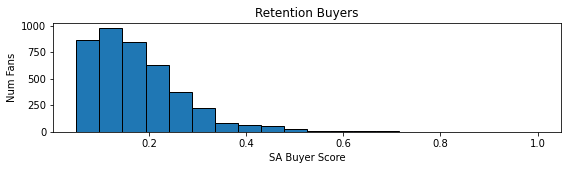

In [25]:
plt.subplot(1, 2, 1) #two rows, 1 column, index 1
plt.title("Retention Buyers")
plt.hist(df_sagemaker_scores["isNextYear_Buyer"], bins=20, edgecolor="black", range=(0.05,1.0))
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,2)
plt.show()